# DC Source Location

[Lindsey Heagy](http://github.com/lheagy)

In this notebook, we examine how the location of the positive electrode impacts the current distribution in the geologic formation. The amplitude and distribution of currents affects our ability to excite a response in a target of geologic interest. 

This notebook was used to produce Figures 12 and 13 in Heagy and Oldenburg, 2018. 

In [1]:
import discretize
from discretize import utils
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import ipywidgets
from string import ascii_lowercase

from SimPEG.EM import TDEM
from SimPEG import Utils, Maps, versions

import casingSimulations as casingSim

from pymatsolver import Pardiso

%matplotlib inline

##  Parameters

To examine the impact of replacing the steel cased well with a solid well, I have run a few simulations using SimPEG and simulating the DC resistivity equations using a finite volume approach on a 3D cylindrical mesh.  

The model setup follows . The electrical conductivities used are:
- Casing $1\times 10^6$ S/m
- Air $3\times10^{-7}$ S/m
- Background $3\times10^{-2}$ S/m
- Inside the casing - same as background

In the first example, the well is 200m long. The thickness of the casing is 12mm. Here, we are interested in examining a top casing source, where one electrode is connected to the top of the casing and a return electrode is some radial distance away on the surface. In the following examples, we will put the return electrode a distance of 2x the length of the well (for the first example, it is 400 m away). For datam we measure the radial electric field along a line $90^\circ$ from the source wire, starting from the well and measuring out to a distance of 400m away. 

### Experiments

From the base example, there are 3 that are setup, you can select one by changing the `experiment` variable or setting your own values for `casing_l`, `sigma_back` and `sigma_air`.

In [2]:
simDir = 'DC_source_locations'  # create a simulation directory where results can be saved. 

In [3]:
casing_l = 1000
sigma_back = 1e-1
casing_d = 10e-2 #10cm diameter
casing_t = 1e-2 #1cm thickness

model = casingSim.model.CasingInHalfspace(
    directory=simDir,
    sigma_casing= 5e6,  # conductivity of the casing (S/m)
    sigma_back = sigma_back,  # conductivity of the background (S/m)
    sigma_inside = sigma_back,  # fluid inside the well has same conductivity as the background
    sigma_air = 1e-4,   # conductivity of the air
    casing_d = casing_d-casing_t,  # 10 cm is outer casing diameter
    casing_l = casing_l,
    casing_t = casing_t, 
    src_a = np.r_[0., np.pi, -1.25],  # put the A electrode just below the surface
    src_b = np.r_[2*casing_l, np.pi, -1.25] # put the return electrode at a distance of 2 x length of well away
)

# adjust the src_a location so it is connected to well
model.src_a = np.r_[model.casing_r, np.pi, -1.25]  

In [4]:
# Here we print the parameters being used to set up the simulation
model.serialize()

{'filename': 'ModelParameters.json',
 'directory': 'DC_source_locations',
 'version': '0.0.7',
 'sigma_casing': 5000000.0,
 'sigma_inside': 0.1,
 'mur_casing': 1.0,
 'mur_inside': 1.0,
 'casing_top': 0.0,
 'casing_l': 1000.0,
 'casing_d': 0.09000000000000001,
 'casing_t': 0.01,
 'sigma_back': 0.1,
 'mur_back': 1.0,
 'sigma_air': 0.0001,
 'surface_z': 0.0,
 'src_a': [0.045000000000000005, 3.141592653589793, -1.25],
 'src_b': [2000.0, 3.141592653589793, -1.25],
 '__class__': 'CasingInHalfspace'}

## Mesh

Here we set up a 3D cylindrical mesh, discretizing in $x$, $\theta$ and $z$. 

To discretize in x, we start by defining the finest region of the mesh, ensuring that we have 4 cells across the thickness of the casing. From there, we expand the cell sizes until we reach the second uniform cell size we want to model at (`csx2`). We then use a constant cell spacing of `csx2` until we have meshed out to the end of the domain in which we want to examine data (`domainx2`). Beyond that, we add padding cells to *"infinity"*

In [5]:
# parameters defining the core region of the mesh
# note that the finest re
csx2 = 25.  # cell size in the x-direction in the second uniform region of the mesh (where we measure data)
csz = 2.5  # cell size in the z-direction 
domainx2 = 500  # go out 500m from the well

# padding parameters
npadx, npadz = 15, 22  # number of padding cells
pfx2 = 1.4  # expansion factor for the padding to infinity in the x-direction
pfz = 1.4

# discretization in theta
# hy = utils.meshTensor([(1, 2, -1.5), (1, 3), (1, 2, 1.5)])
hy = np.ones(1)
# hy = np.r_[hy, hy]
hy = hy*2*np.pi / hy.sum()

# set up a mesh generator which will build a mesh based on the provided parameters
# and casing geometry
cylMeshGen = casingSim.CasingMeshGenerator(
    directory=simDir,  # directory where we can save things
    modelParameters=model,  # casing parameters
    npadx=npadx,  # number of padding cells in the x-direction
    npadz=npadz,  # number of padding cells in the z-direction
    domain_x=domainx2,  # extent of the second uniform region of the mesh 
    hy=hy,   # cell spacings in the 
    csx1=model.casing_t/4.,  # use at least 4 cells per across the thickness of the casing
    csx2=csx2,  # second core cell size
    csz=csz,  # cell size in the z-direction
    pfx2=pfx2,  # padding factor to "infinity"
    pfz=pfz  # padding factor to "infinity" for the z-direction
)

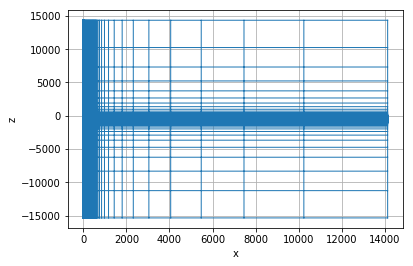

In [6]:
cylMeshGen.mesh.plotGrid()

In [7]:
src_theta = model.src_a[1] + hy[0]/2.

model.src_a[1] = src_theta
model.src_b[1] = src_theta

## Models to compare to

In [8]:
no_casing = model.copy()
no_casing.sigma_casing = no_casing.sigma_back

In [9]:
# put the models in a dictionary for convienence 
model_names = ['casing', 'baseline']
modelDict = dict(zip(model_names, [model, no_casing]))

In [10]:
# Assign physical properties on the mesh
physpropsDict = {
    key: casingSim.model.PhysicalProperties(cylMeshGen, modelDict[key]) 
    for key in model_names
}

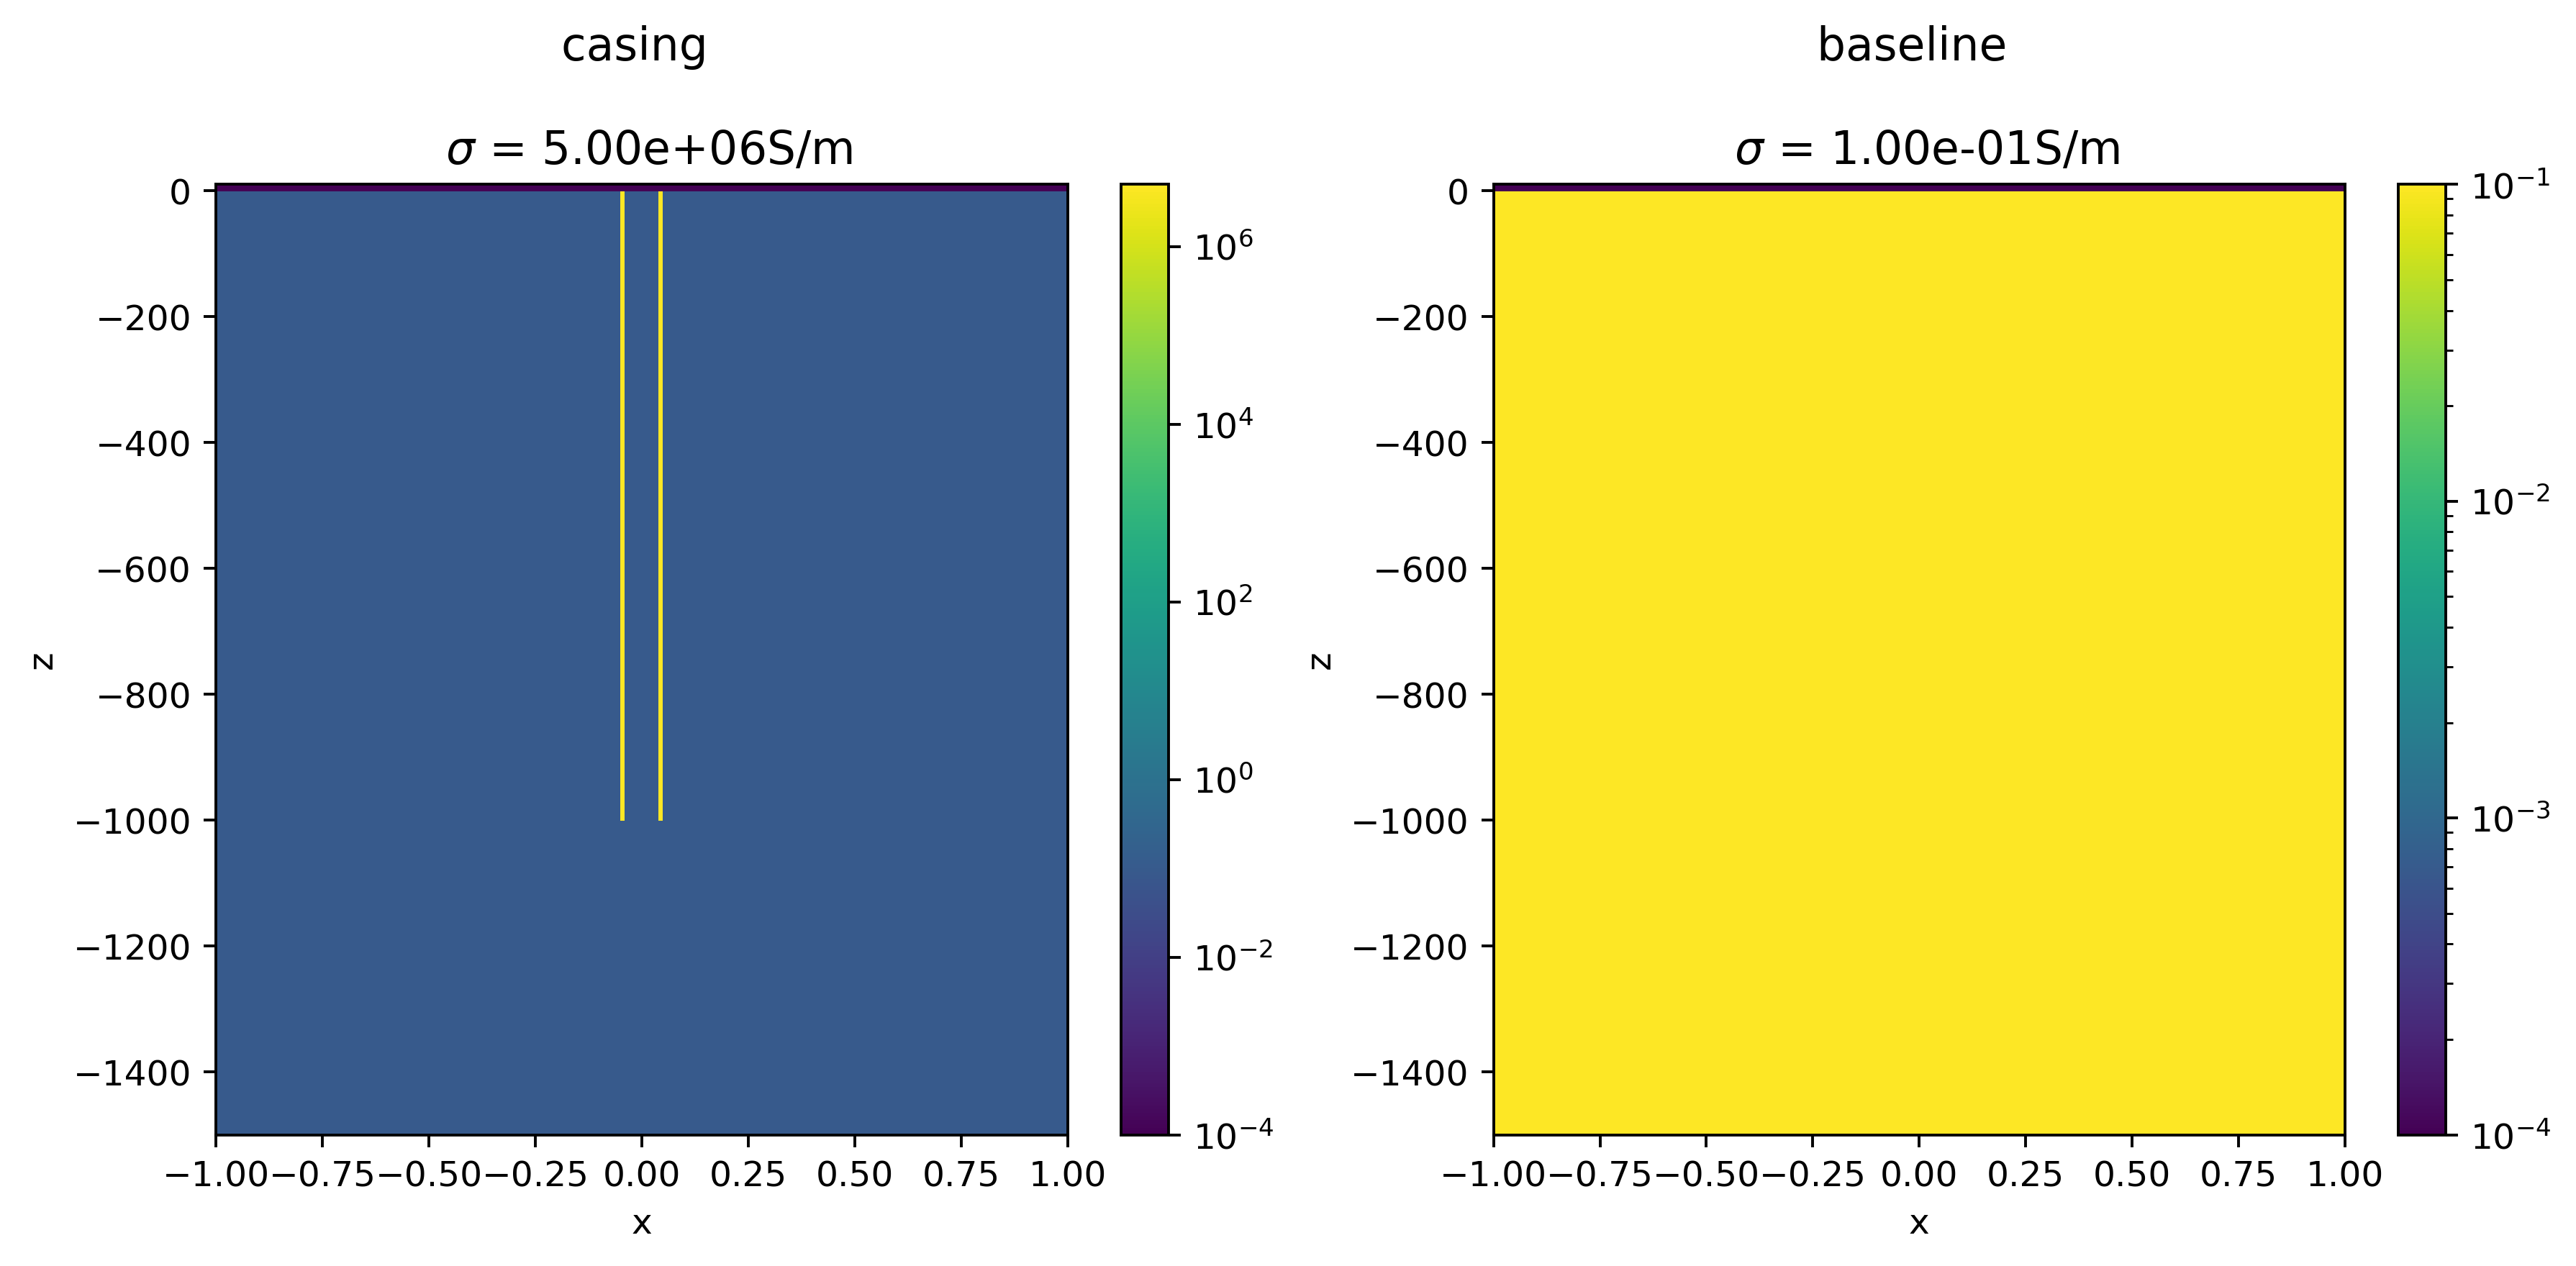

In [11]:
# Plot the models
xlim = np.r_[-1, 1]  # x-limits in meters
zlim = np.r_[-1.5*model.casing_l, 10.]  # z-limits in meters. (z-positive up)

fig, ax = plt.subplots(1, len(model_names), figsize=(6*len(model_names), 5), dpi=350)
if len(model_names) == 1:
    ax=[ax]
    
for a, title in zip(ax, model_names):
    pp = physpropsDict[title]
    pp.plot_sigma(
        ax=a, 
        pcolorOpts={'norm':LogNorm()}  # plot on a log-scale
    )
    a.set_title('{} \n\n $\sigma$ = {:1.2e}S/m'.format(title, pp.modelParameters.sigma_casing), fontsize=13)
#     cylMeshGen.mesh.plotGrid(ax=a, slice='theta') # uncomment to plot the mesh on top of this
    a.set_xlim(xlim)
    a.set_ylim(zlim)

## Source locations

In [12]:
# Set up 4 sources, top casing, top & not coupled, downhole, downhole not coupled

src_a = np.vstack([
    [model.casing_r, src_theta, -1.25],
    [model.casing_r + 0.1, src_theta, -1.25],
    [model.casing_r, src_theta, -casing_l/2.],
#     [0., src_theta, -casing_l/2.],
    [model.casing_r, src_theta, -casing_l + 5.],
#     [0., src_theta, -casing_l + 5.],
    [0., src_theta, -casing_l + 1.25],
    [0., src_theta, -casing_l - 1.25],
    [0., src_theta, -casing_l - 5.],
    [0., src_theta, -casing_l - 10.],
    [0., src_theta, -casing_l - 20.],
#     [0., src_theta, -casing_l - 100.],
#     [model.casing_b+cylMeshGen.csx1*2, src_theta, -casing_l + 5.]
])

src_b = np.ones((src_a.shape[0],1)) * model.src_b

src_names = [
    "top casing",
    "surface",
    "center", 
#     "center, disconnected",
    "downhole",
#     "downhole, disconnected",
    "1.25m above bottom",
    "1.25m below hole",
    "5m below hole",
    "10m below hole",
    "20m below hole",
#     "100m below hole",
#     "outside hole"
]

## set up a DC simulation

In [13]:
simDict = {}
for title in model_names:
    simDict[title] = casingSim.run.SimulationDC(
        modelParameters=modelDict[title], directory=simDir, 
        meshGenerator=cylMeshGen, src_a=src_a, src_b=src_b
    )


Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.


In [14]:
%%time
fieldsDict = {}
for title in model_names:
    print('--- Running {} ---'.format(title))
    fieldsDict[title] = simDict[title].run()
    print('\n')

--- Running casing ---
Validating parameters...
      max x: 14124.70836130856, min z: -15352.855805436326, max z: 14352.855805436311, nC: 41768
Saved DC_source_locations/simulationParameters.json
Starting SimulationDC
Using <class 'pymatsolver.direct.Pardiso'> Solver
   ... Done. Elapsed time : 0.3532862663269043


--- Running baseline ---
Validating parameters...
      max x: 14124.70836130856, min z: -15352.855805436326, max z: 14352.855805436311, nC: 41768
Saved DC_source_locations/simulationParameters.json
Starting SimulationDC
Using <class 'pymatsolver.direct.Pardiso'> Solver
   ... Done. Elapsed time : 0.20868587493896484


CPU times: user 1.56 s, sys: 96.7 ms, total: 1.65 s
Wall time: 600 ms


## Plot Results



In [15]:
src_names

['top casing',
 'surface',
 'center',
 'downhole',
 '1.25m above bottom',
 '1.25m below hole',
 '5m below hole',
 '10m below hole',
 '20m below hole']

In [16]:
from matplotlib import rcParams
rcParams['font.size'] = 12

In [17]:
mesh = cylMeshGen.mesh

### Plot the source locations on the mesh

Text(0, 0.5, 'y (m)')

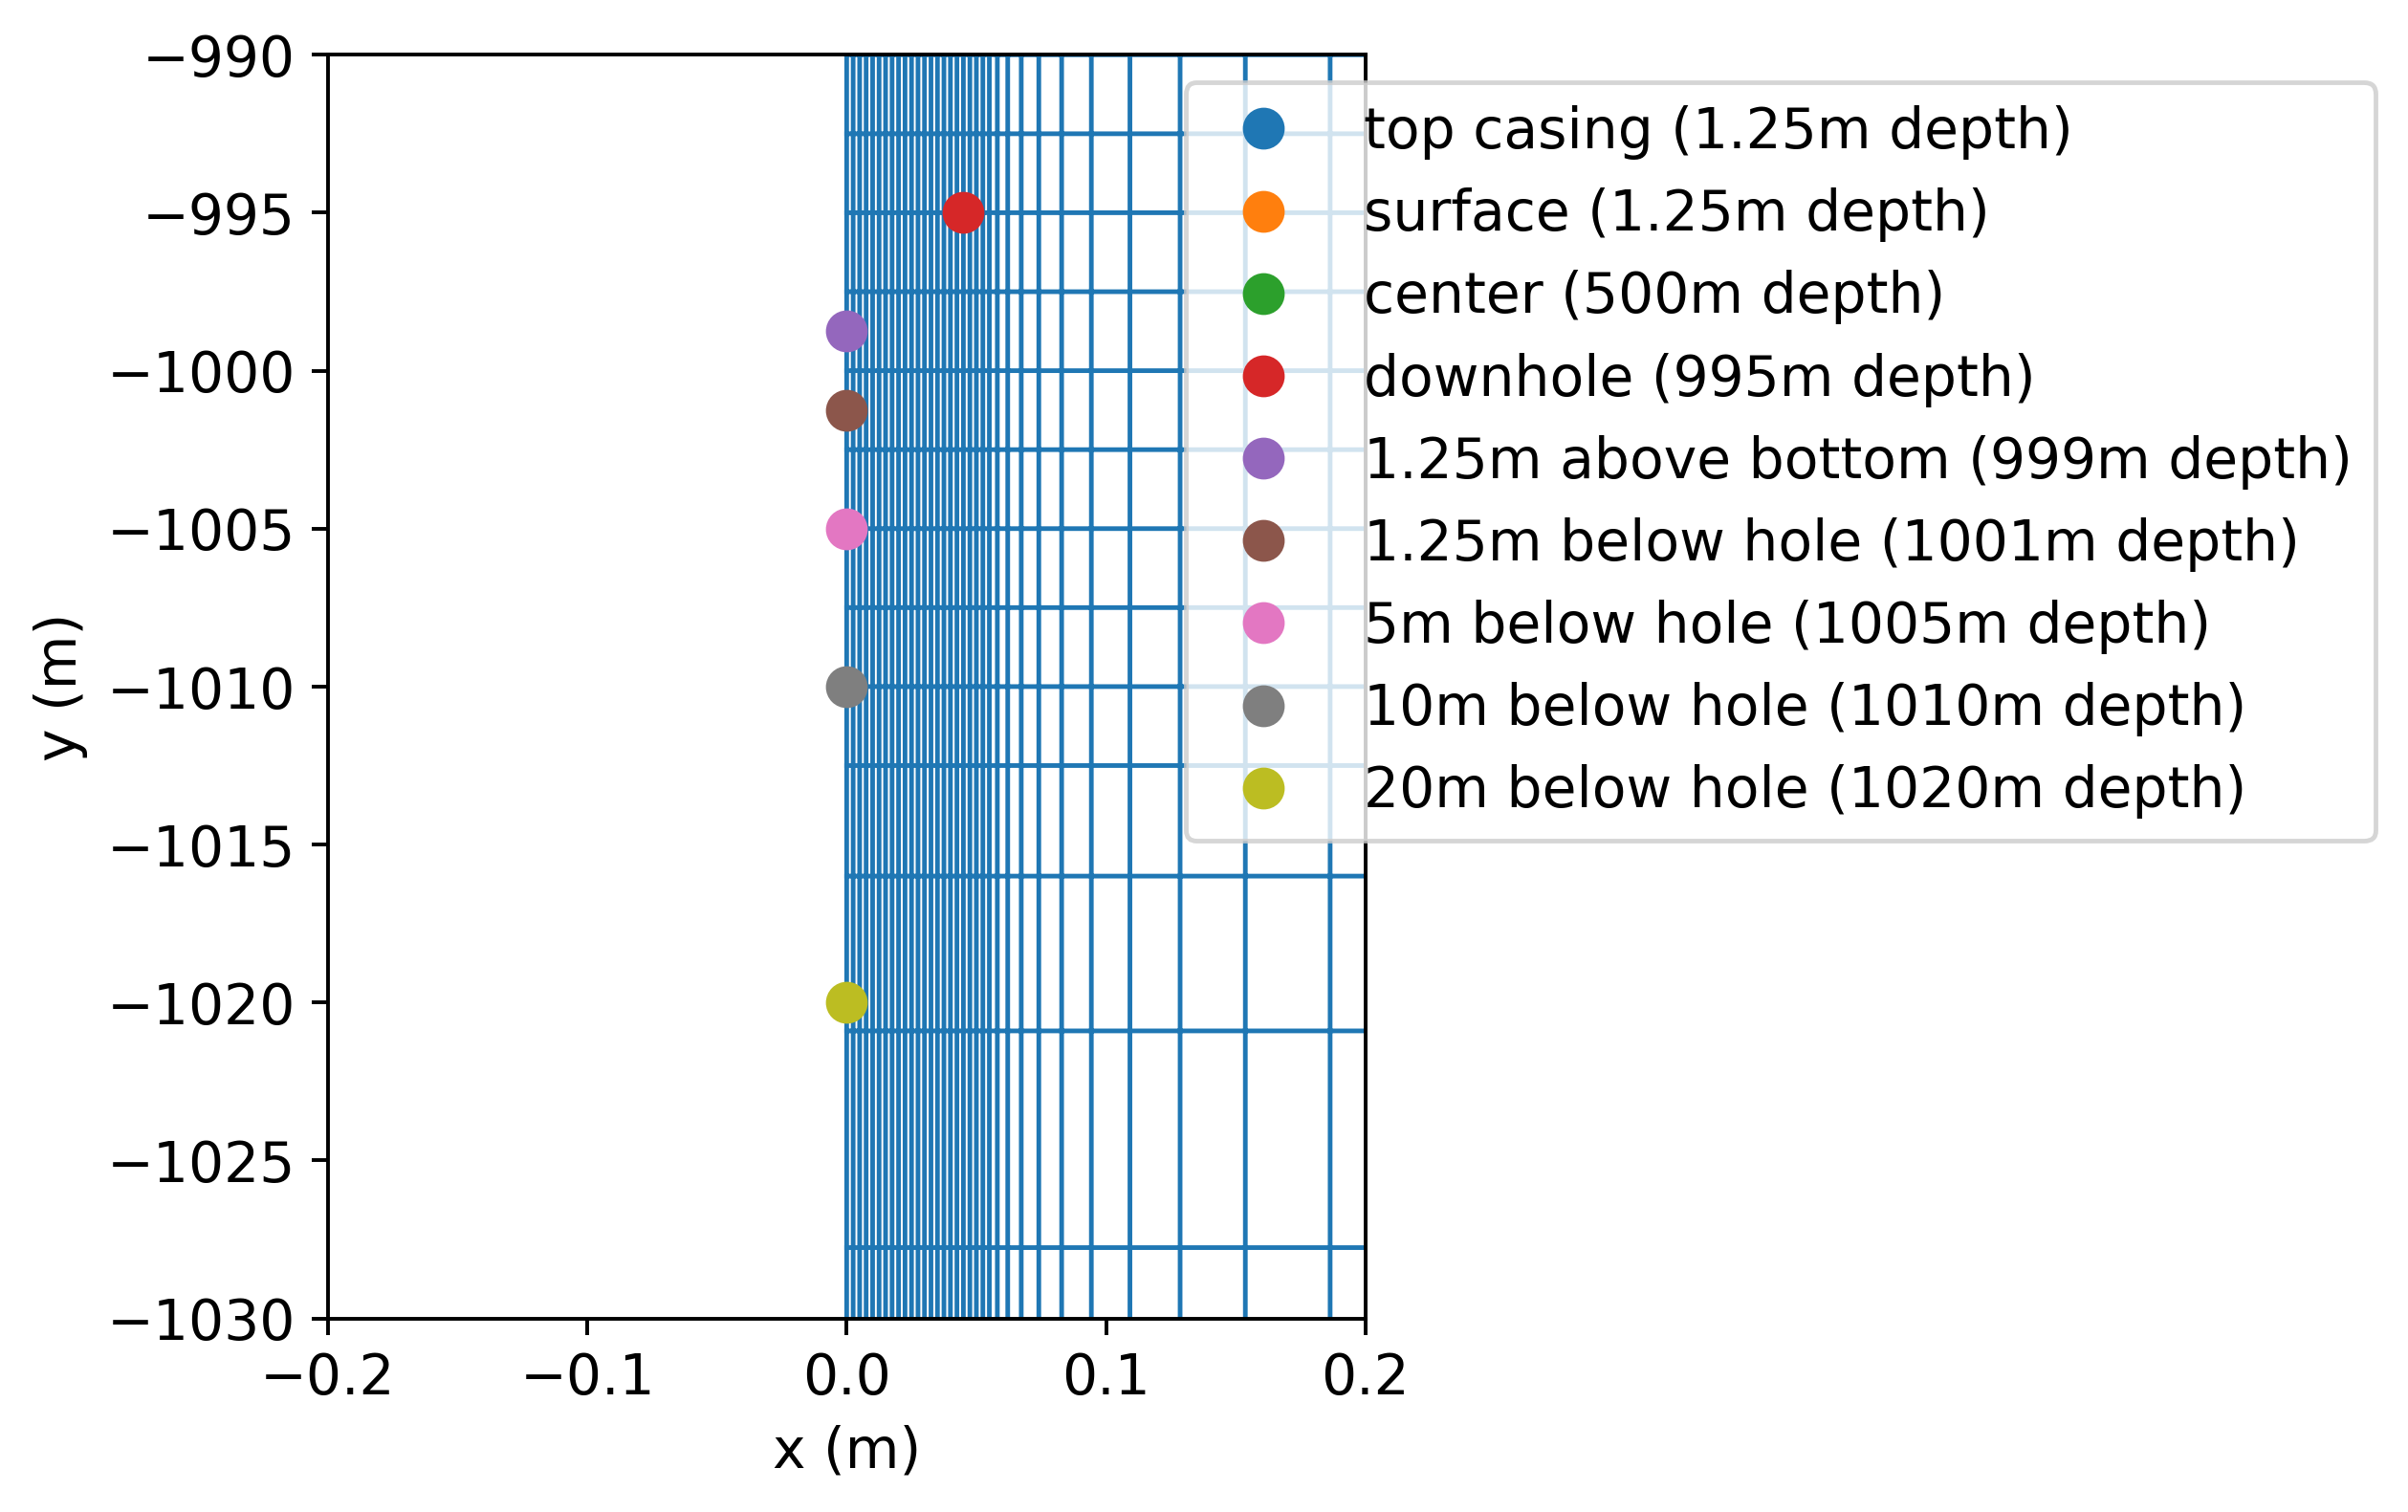

In [18]:
xlim = 0.2 * np.r_[-1, 1]
# symbols = ['v', 'v', '>', '>', 'v', 'C3s']

fig, ax = plt.subplots(1, 1, figsize=(4, 5), dpi=350)
# cylMeshGen.mesh.plotGrid(ax=ax, slice='theta')
mesh.plotGrid(ax=ax)
out = physpropsDict['baseline'].plot_sigma(
    ax=ax, 
    pcolorOpts={'norm':LogNorm(), 'cmap': 'Greys'},  # plot on a log-scale
    clim = np.r_[sigma_back, 1e20], 
    show_cb = False
)

ax.plot(xlim, np.zeros(2), color='0.2')

for i in range(src_a.shape[0]):
    if src_a[i, 2] < -10:
        label = "{} ({:1.0f}m depth)".format(
            src_names[i], -src_a[i, 2]
        )
    else:
        label = "{} ({:1.2f}m depth)".format(
            src_names[i], -src_a[i, 2]
        )
    ax.plot(src_a[i, 0], src_a[i, 2], 'o', ms=8, color="C{}".format(i), label=label)
    ax.plot(src_b[i, 0], src_b[i, 2], 'o', ms=8, color="C{}".format(i))
    
ax.legend(bbox_to_anchor=[2, 1])
ax.set_xlim(xlim) #src_b[:, 0].max()])
# ax.set_ylim([-1.1 * modelDict[model_names[0]].casing_l, 10])
ax.set_ylim([-1030, -990])
ax.set_title('')
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')


### Figure 11 - source locations

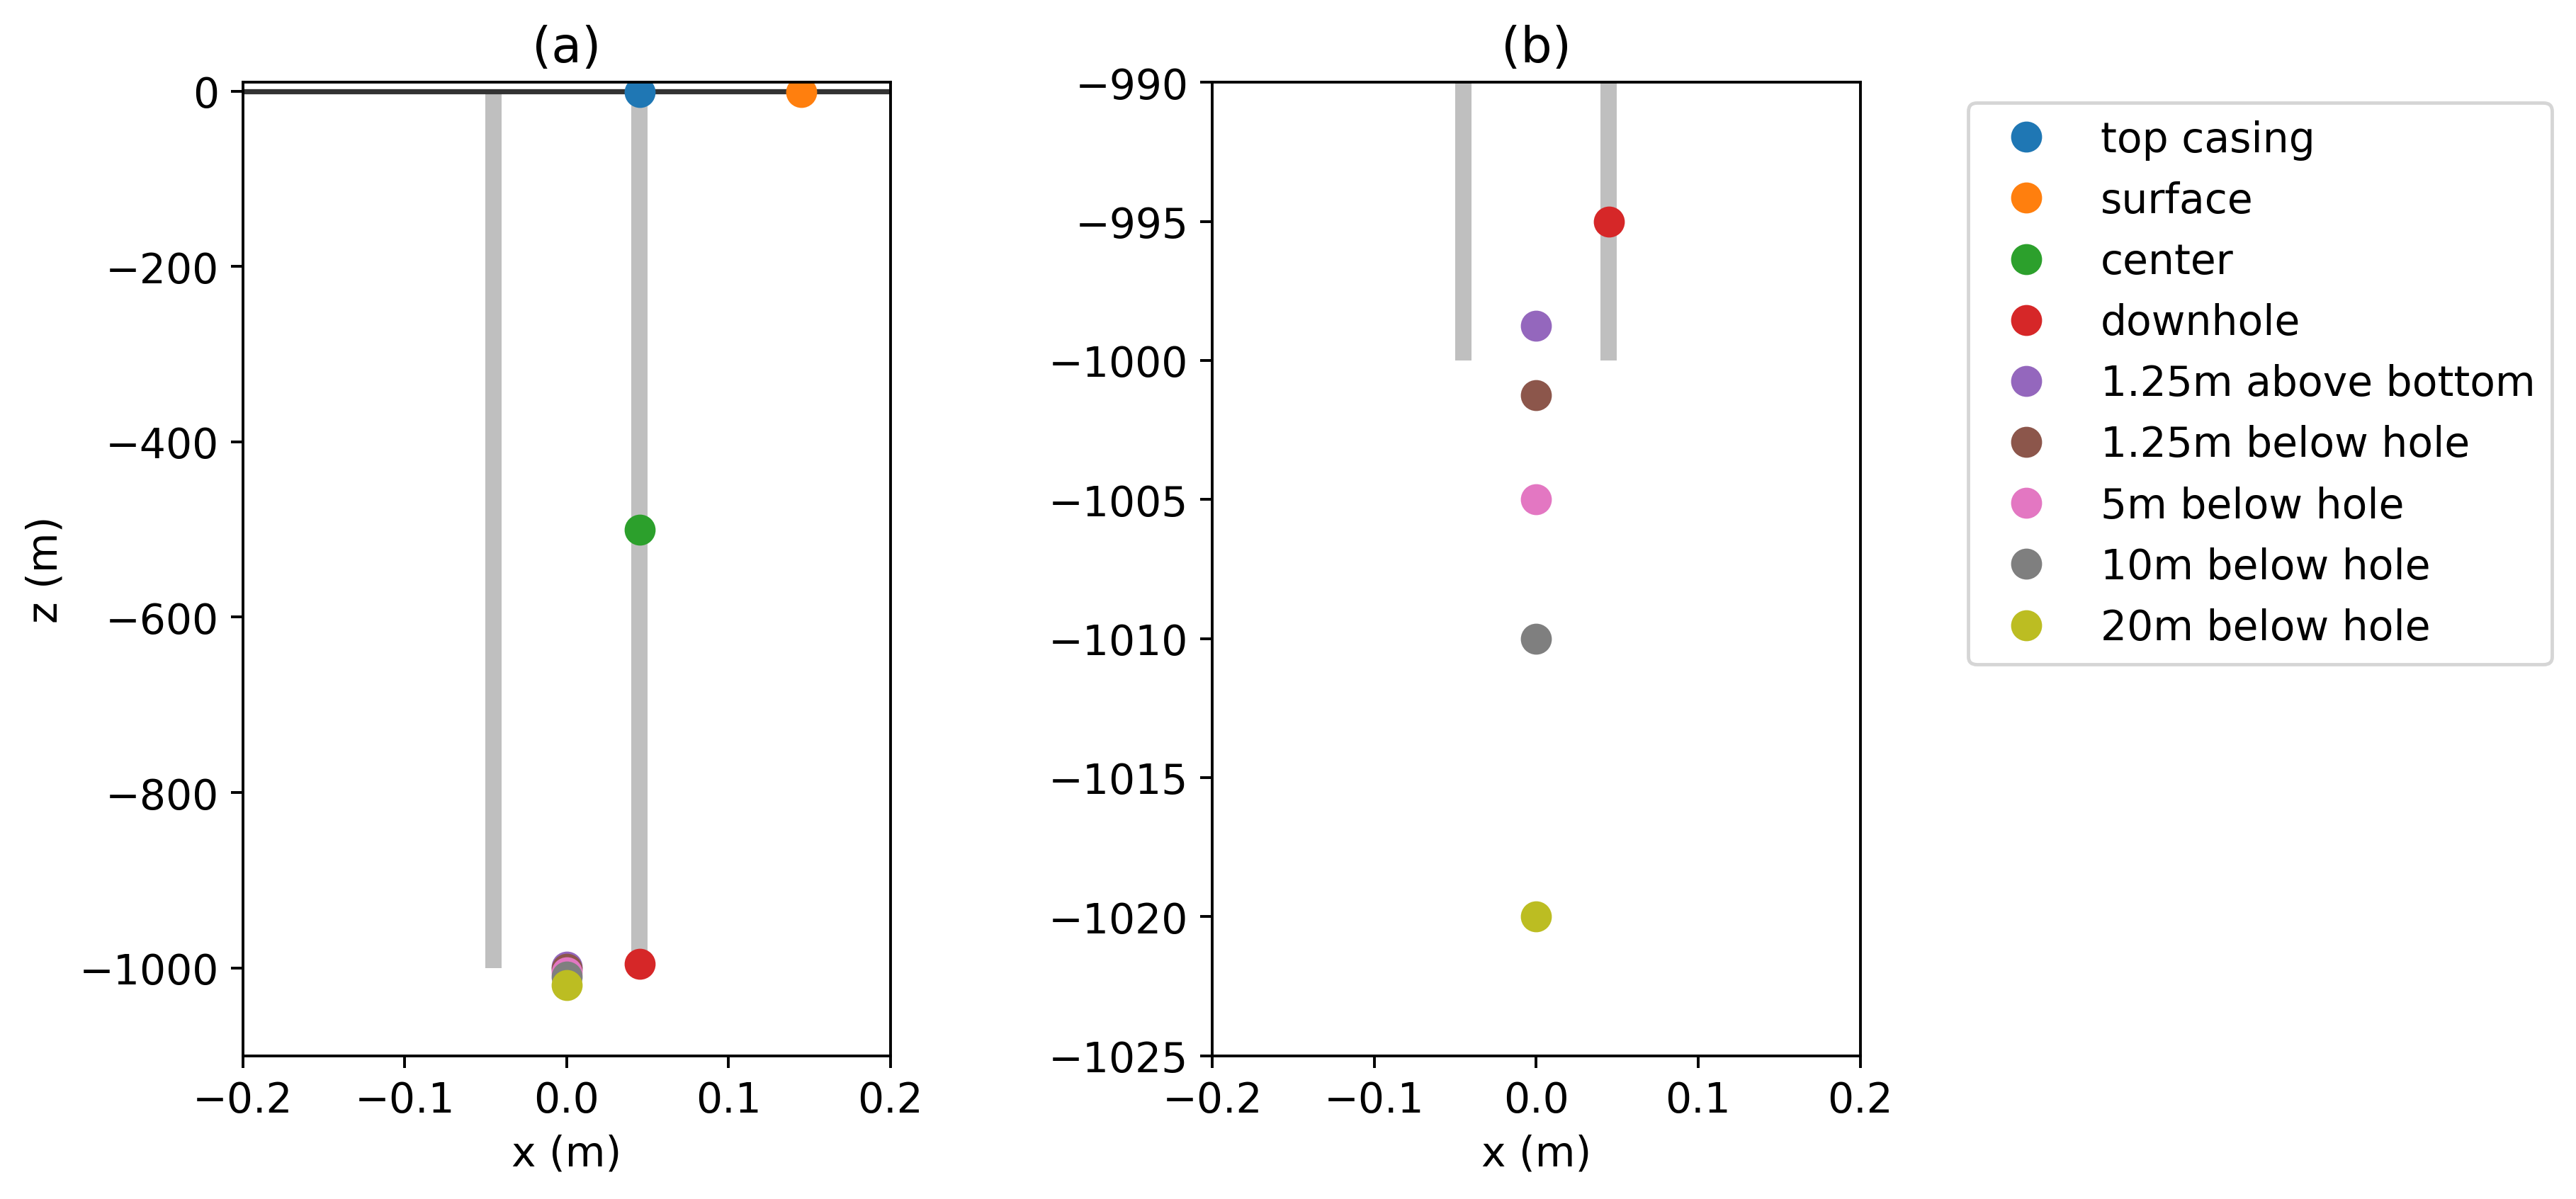

In [19]:
# Plot the source location

xlim = 0.2 * np.r_[-1, 1]
# symbols = ['v', 'v', '>', '>', 'v', 'C3s']

fig, ax = plt.subplots(1, 2, figsize=(8, 5), dpi=350)

for j, a in enumerate(ax): 
    # cylMeshGen.mesh.plotGrid(ax=ax, slice='theta')
    out = physpropsDict['casing'].plot_sigma(
        ax=a, 
        pcolorOpts={'norm':LogNorm(), 'cmap': 'Greys'},  # plot on a log-scale
        clim = np.r_[sigma_back, 1e20], 
        show_cb = False
    )

    a.plot(xlim, np.zeros(2), color='0.2')

    for i in range(src_a.shape[0]):
        if src_a[i, 2] < -10:
            label = "{}".format( # ({:1.0f}m depth)
                src_names[i], -src_a[i, 2]
            )
        else:
            label = "{}".format(  #{:1.2f}m depth)"
                src_names[i], -src_a[i, 2]
            )
        a.plot(src_a[i, 0], src_a[i, 2], 'o', ms=8, color="C{}".format(i), label=label)
        a.plot(src_b[i, 0], src_b[i, 2], 'o', ms=8, color="C{}".format(i))
        
        a.set_xlim(xlim) #src_b[:, 0].ma()])
        a.set_title('')
        a.set_xlabel('x (m)')
    a.set_title("({})".format(ascii_lowercase[j]))

plt.tight_layout()

ax[0].set_ylabel('z (m)')
ax[0].set_ylim([-1.1 * modelDict[model_names[0]].casing_l, 10])
ax[1].set_ylim([-1025, -990])

ax[1].set_ylabel('')
ax[1].legend(bbox_to_anchor=[2.1, 1])


fig.savefig('../figures/electrode_location', bbox_inches="tight")
fig.savefig('../arxiv-figures/electrode_location', bbox_inches="tight", dpi=150)


### Figure 12: plot currents in formation

In [20]:
rcParams['font.size'] = 12

In [47]:
# plot currents in casing

epsilon = 1e-16

def plot_current_density(
    ax=None, radius=50, model='casing', theta_ind=0, 
    src_ind=0, linestyle='-', marker=None, color=None, label=None, 
    alpha=None, lw=None
):
    
    src = simDict[model].survey.srcList[src_ind]
    label = src_names[src_ind] if label is None else label
    x_ind = np.absolute(mesh.vectorCCx - radius) == np.min(np.absolute(mesh.vectorCCx - radius))

    j = mesh.aveF2CCV * fieldsDict[model][src, 'j']
    j = j.reshape((mesh.nC, int(len(j)/mesh.nC)), order='F')
    jx = discretize.utils.mkvc(j[:,0].reshape(mesh.vnC, order='F')[x_ind, theta_ind, :])
    jz = discretize.utils.mkvc(j[:,1].reshape(mesh.vnC, order='F')[x_ind, theta_ind, :])
    jt = np.sqrt(jx**2 + jz**2)

    ax.semilogy(
        -cylMeshGen.mesh.vectorCCz, jt, label=label, color="C{}".format(src_ind) if color is None else color, 
        ls=linestyle, alpha=alpha, marker=marker, lw=lw
    )
    
def plot_current_density_multisrc(ax=None, radius=50, model='casing', theta_ind=0, linestyle='-'):
   
    if ax is None: 
        fig, ax = plt.subplots(1, 1, figsize=(7, 3.5), dpi=350)
        ax = discretize.utils.mkvc(ax)
    
    f = fieldsDict[model]
    
    for i in range(len(simDict[model].survey.srcList)):
        plot_current_density(
            ax=ax, radius=radius, model=model, theta_ind=theta_ind, src_ind=i, 
            linestyle='--' if i == 3 else linestyle,
            lw = 3 if i == 3 else None
        )
        
    ax.set_ylabel('$|j|$ (A/m$^2$)')
      
    return ax

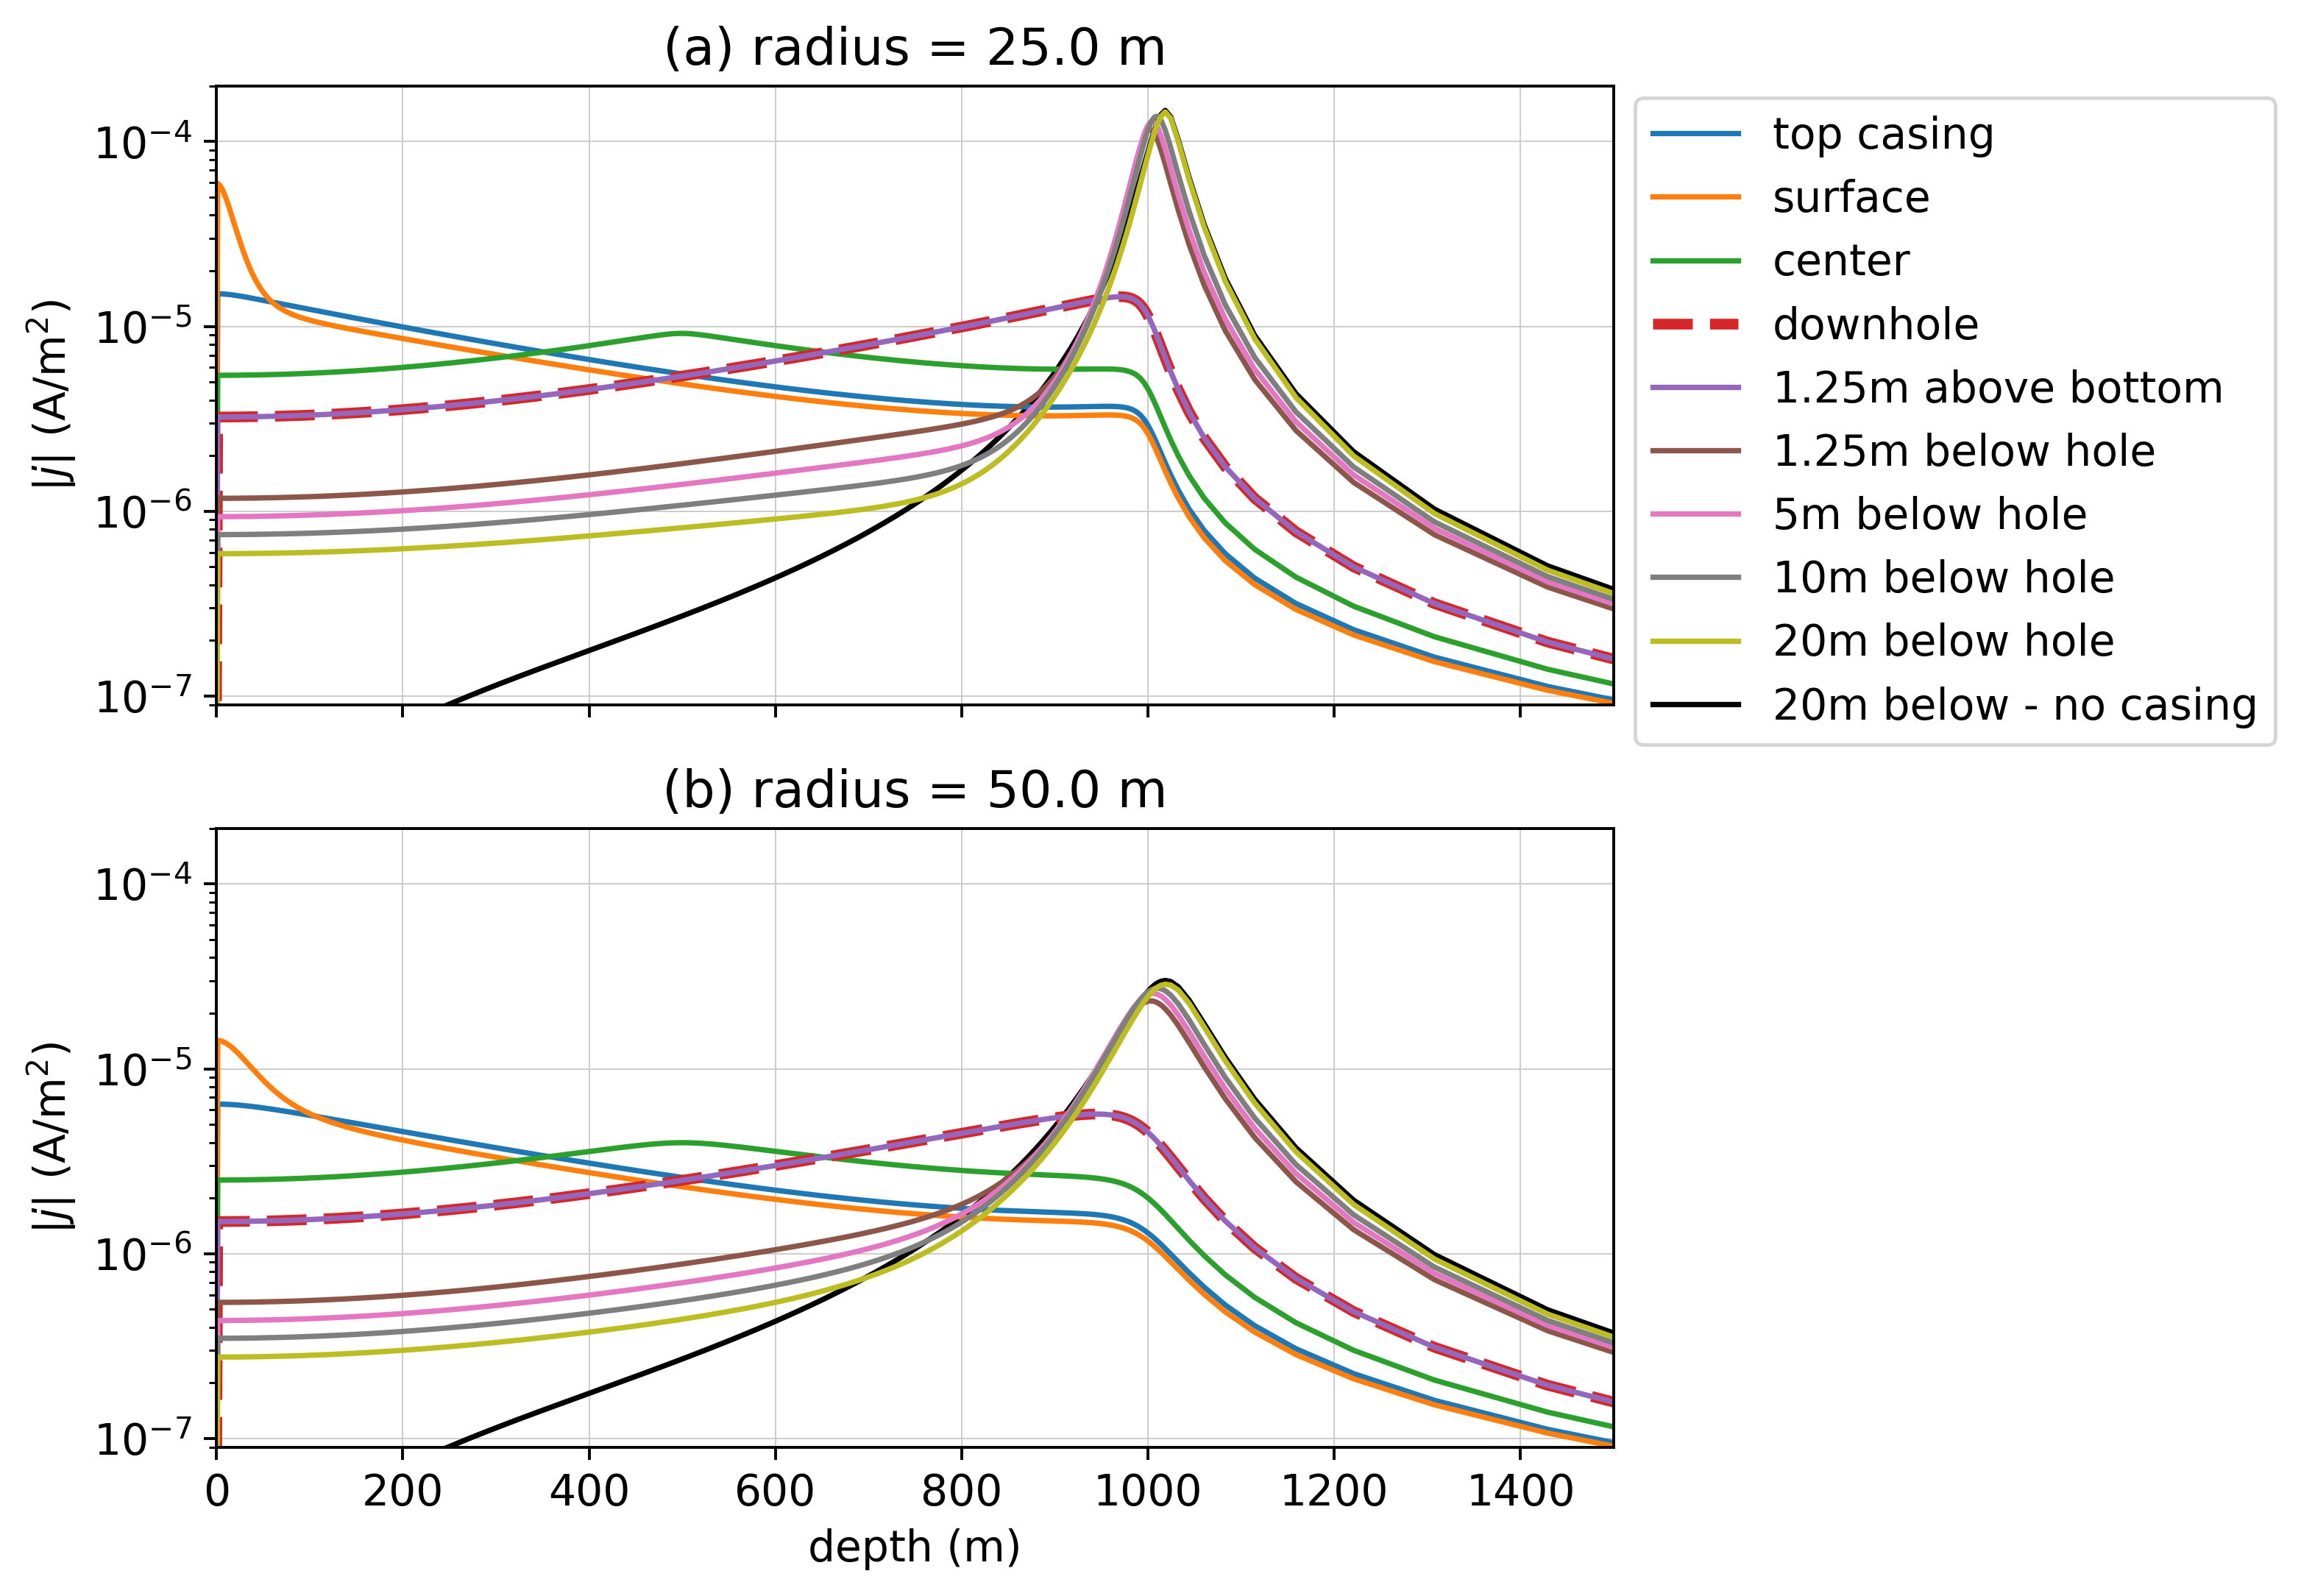

In [48]:
fig, ax = plt.subplots(2, 1, figsize=(7, 7), dpi=350)
r = [25., 50.]  #, 100.]

for i, a in enumerate(ax): 
    a.set_xlim([0., 1.5*casing_l])
#         a.legend() 
    a.set_xlabel('depth (m)') 
    a.set_title('({}) radius = {} m'.format(ascii_lowercase[i], r[i]))
    a.grid('both', linestyle='-', linewidth=0.4, color=[0.8, 0.8, 0.8])
    plot_current_density(ax=a, model='baseline', radius=r[i], color="k", src_ind=src_a.shape[0]-1, label= "") #"20m below - no casing")
    plot_current_density_multisrc(ax=a, radius=r[i])
    a.plot(np.nan, np.nan, label= "20m below - no casing", color="k") # hack to put the label at the bottom

    
    if i < len(r) -1 :
        a.set_xticklabels(['']*len(a.get_xticklabels()))
        a.set_xlabel('')

#         a.set_ylim([6e-5, 1])
#         a.set_ylim([1e-7, 6e-4])

[a.set_ylim([9e-8, 2e-4]) for a in ax]
# [a.set_ylim([1e-6, 1e-5]) for a in ax]


ax[1].legend(bbox_to_anchor=[1., 1.1])
# plt.tight_layout()
# ax[1].set_ylim([1e-9, 1e-1])

fig.savefig('../figures/electrode_location_currents', bbox_inches="tight", dpi=350)
fig.savefig('../arxiv-figures/electrode_location_currents', bbox_inches="tight", dpi=200)

## Charges

How do the charges change with different casing models?

### Widget for viewing charges

There are 3 panels, the true (left), if we were to replace the well with solid steel (center) and if we choose sigma to preserve the integrated conductance (right). For reference, I have plotted the true casing cross section.

The widgets available to you are
- **theta_ind**: [0, ntheta slices] Which azimuth should we slice through
- **clim_max**: max value on the colorbar so you can saturate it
- **max_depth**: max z-limit for the plot
- **top**: top of the plot (z)

observations:
- (sanity checks): in all charges at interface between casing and formation. All positive charges (positive electrode connected to casing
- charge distribution more uniform along length of casing for solid steel (also makes sense: better conductor)

In [23]:
viewer = casingSim.FieldsViewer(
    sim_dict=simDict, fields_dict=fieldsDict, model_keys=model_names
)

In [24]:
viewer.widget_cross_section()

interactive(children=(FloatText(value=0.1, description='max_r'), FloatText(value=-10.0, description='min_depth…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

In [2]:
versions('HTML')